## Задание 2
1. Загрузить и обработать данные (инструкция по содержанию и расположению данных в файле data.docx).  
2. Выполнить прогноз среднесуточной цены продажи электроэнергии по ЦЗ «Европа» на 1 месяц (горизонт прогноза – 30 суток).  
3. Отобразить на графике обучающую выборку, валидационную (если использовалась) и прогноз (выделить разным цветом).  

Необходимо использовать данные из файлов, расположенных по адресу: https://drive.google.com/drive/folders/1U31X2-mDZ1-xrf6-gRyby8KiEzXaVXA0?usp=sharing

### Описание данных
**ЦЗ (ценовая зона)** – в данном случае рассматривается только ценовая зона «Европа». Территориально ценовая зона «Европа» включает в себя Европейскую часть и Урал.  
**ЗСП (зона свободного перетока)** – некоторая территория, которая состоит из субъектов Российской Федерации или их частей. В разбивке по ЗСП представлены цена продажи электроэнергии и некоторые объемные параметры. Последние две цифры в коде ЗСП соответствуют номеру, указанному на карте. Территории, которые не обозначены цифровым кодом на карте к ценовой зоне «Европа» не относятся.  
**План ГЭС (МВт*ч)** – плановый объем производства электроэнергии ГЭС (гидроэлектростанции) в ЗСП.  
**План АЭС (МВт*ч)** – плановый объем производства электроэнергии АЭС (атомной электростанцией) в ЗСП.  
**План ТЭС (МВт*ч)** – плановый объем производства электроэнергии ТЭС (тепловой электростанцией) в ЗСП. К тепловым электростанциям относятся все электростанции, которые производят электроэнергию путем сжигания органического топлива (газ, уголь, мазут).  
**ТЭС мин (МВт*ч)** – технологически минимальная мощность включенного в работу теплового генерирующего оборудования в ЗСП.  
**ТЭС макс (МВт*ч)** – технологически максимальная мощность включенного в работу теплового генерирующего оборудования в ЗСП.  
**Потребление (МВт*ч)** – плановый объем потребления электроэнергии, заявленный потребителями в ЗСП.  
**Экспорт/Импорт (МВт*ч)** – плановый объем перетока электроэнергии между соседними ЗСП. Экспорт – переток электроэнергии из данной ЗСП в соседние. Импорт – переток электроэнергии в данную ЗСП из соседних.  
**План СЭС, ВЭС, ВИЭ (МВт*ч)** – плановый объем производства электроэнергии солнечными, ветровыми и другими ВИЭ в данной ЗСП соответственно.
**Ценопринимающее предложение (МВт*ч)** – объем электроэнергии, в отношении которого поставщики в ценовой заявке на отбор заявляют цену равную нулю. При этом на объем мощности соответствующей технологически минимальной мощности поставщики обязаны подать ценопринимающую заявку. Данная величина фиксируется только по ценовой зоне.  
**Ценопринимание сверх минимальной мощности (МВт*ч)** – объем электроэнергии, в отношении которого поставщик в ценовой заявке на отбор заявил цену равную нулю. При этом на указанный объем у поставщика не было требования подавать ценопринимание. Данное действие является часть его ценовой стратегии.  
**Цена продажи электроэнергии (руб./МВт*ч)** – параметр, который необходимо спрогнозировать.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from pmdarima.preprocessing import FourierFeaturizer
from pmdarima import auto_arima

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Загрузим данные за три года в один датасет "df"

url_for_df_2018 = 'https://docs.google.com/spreadsheets/d/1KYte175JPpB4TIzkD8mAm1u2UXZr3ia9/edit?usp=sharing&ouid=104559265259393209200&rtpof=true&sd=true'
url_for_df_2019 = 'https://docs.google.com/spreadsheets/d/1GezXvNlJA0axMWCF63mrUSUEQ8nvEAvd/edit?usp=sharing&ouid=104559265259393209200&rtpof=true&sd=true'
url_for_df_2020 = 'https://docs.google.com/spreadsheets/d/1zjY_TEismdxgkt1D1sl1L-bi8WYGqw9h/edit?usp=sharing&ouid=104559265259393209200&rtpof=true&sd=true'
list_url = [url_for_df_2018, url_for_df_2019, url_for_df_2020]

for i, url in enumerate(list_url):
    url = 'https://docs.google.com/uc?id=' + url.split('/')[-2]
    df_year = pd.read_excel(url, parse_dates=['Дата'], index_col='Дата')
    if i == 0:
        df = df_year
    else:        
        df = df.append(df_year)

In [4]:
df.head()

,ЦЗ,ЗСП,Час,"План ГЭС, МВт*ч","План АЭС, МВт*ч","План ТЭС, МВт*ч","ТЭС мин, МВт*ч","ТЭС макс, МВт*ч","Потребление, МВт*ч","Экспорт, МВт*ч","Импорт, МВт*ч","План СЭС, МВт*ч","План ВЭС, МВт*ч","План ВИЭ, МВт*ч","Ценопринимающее предложение, МВт*ч","Ценопринимание сверх минимальной мощности, МВт*ч","Цена продажи, руб./МВт*ч"
Дата,,,,,,,,,,,,,,,,,
2018-01-01,Европа,FZUROE07,8,145.6,616.0,15310.118,12985.703,18417.555,16133.167,1724.097,2122.273,8.3,0.0,0,82858.55,6103.482,776.25
2018-01-01,Европа,FZURTU08,8,0.0,0.0,11906.500,8014.692,12166.200,9971.934,1658.871,29.774,0.0,0.0,0,82858.55,6103.482,685.40
2018-01-01,Европа,FZVLBS15,8,120.0,4073.0,576.000,576.000,640.000,1375.474,3260.660,1.122,0.6,0.0,0,82858.55,6103.482,781.87
2018-01-01,Европа,FZVLOE13,8,500.0,49.5,3857.360,3777.730,4461.390,5812.795,1369.469,2873.540,0.0,3.5,0,82858.55,6103.482,823.30
2018-01-01,Европа,FZYUAS18,8,0.0,0.0,431.500,326.297,531.500,532.284,30.329,154.762,2.0,0.0,0,82858.55,6103.482,890.73


In [5]:
# Переименуем названия колонок для убийства работы с ними 

column_names = {
                'ЦЗ':'price_zone', 
                'ЗСП':'free_flow_zone',
                'Час':'hour',
                'План ГЭС, МВт*ч':'plan_HPS', 
                'План АЭС, МВт*ч':'plan_APS',
                'План ТЭС, МВт*ч':'plan_TPS', 
                'ТЭС мин, МВт*ч':'TPS_min', 
                'ТЭС макс, МВт*ч':'TPS_max',
                'Потребление, МВт*ч':'consumption', 
                'Экспорт, МВт*ч':'export', 
                'Импорт, МВт*ч':'import',
                'План СЭС, МВт*ч':'plan_SPS', 
                'План ВЭС, МВт*ч':'plan_WPS', 
                'План ВИЭ, МВт*ч':'plan_RES',
                'Ценопринимающее предложение, МВт*ч':'price_null_offer',
                'Ценопринимание сверх минимальной мощности, МВт*ч':'price_null_offer_over_min',
                'Цена продажи, руб./МВт*ч':'sale_price'
                }
df.rename(columns=column_names, inplace=True)
df.index.rename('date', inplace=True)

In [6]:
# Так как необходимо предсказать среднесуточной цены, 
# то произведем ресемплинг данных по средним значениям за сутки
# Так же уберем колонку с часами 'hour'

df_per_day = df.resample('1d').mean().iloc[:,1:]

In [7]:
df_per_day.head()

,plan_HPS,plan_APS,plan_TPS,TPS_min,TPS_max,consumption,export,import,plan_SPS,plan_WPS,plan_RES,price_null_offer,price_null_offer_over_min,sale_price
date,,,,,,,,,,,,,,
2018-01-01,362.014947,1558.136667,3992.415700,3289.403000,4663.683394,5689.645258,1475.733022,1427.324747,3.200861,0.652722,0.0,83557.053333,5441.055375,1011.108528
2018-01-02,396.546617,1489.100556,4142.549911,3292.591444,4675.726839,5785.262508,1596.544372,1538.811164,2.231889,1.060778,0.0,83175.086250,5534.033667,1151.511167
2018-01-03,435.114664,1439.498889,4221.336542,3312.586583,4700.529139,5855.870194,1584.128833,1530.422042,1.799389,0.785611,0.0,83904.132917,6125.355875,1220.935000
2018-01-04,450.038008,1368.335000,4376.549656,3365.554692,4780.645533,5957.162692,1576.168247,1523.510028,1.767528,1.039000,0.0,83483.755833,5750.659083,1274.934472
2018-01-05,458.604672,1372.190556,4443.102969,3454.938361,4880.648564,6003.815508,1634.332242,1554.408989,1.601694,0.339444,0.0,84750.559583,5509.438667,1221.152639


In [8]:
def test_dickey_fuller(timeseries, a=0.05):  
    '''
    Функция определения стационарности ряда при помощи критерия Дики-Фуллера
    '''
    test_dickey_fuller = sm.tsa.stattools.adfuller(timeseries)
    print(f'Критерий Дики-Фуллера: p_value = {test_dickey_fuller[1]:.5f}')
    if test_dickey_fuller[1] < a: 
        print('Единичных корней нет => ряд стационарен')    
    else:
        print('Есть единичные корни => ряд не стационарен')


def plot_timeseries(timeseries, rolling_mean=14, lags=50):
    '''
    Функция отрисовки графика временного ряда (по дням) совместно с графиками ACF и PACF
    '''
    timeseries_rolling = timeseries.rolling(rolling_mean).mean()
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(15, 12))
        layout = (2, 2)   
        ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))    
        ax.plot(timeseries, lw=1)
        ax.plot(timeseries_rolling, label='rolling_mean', lw=0.8)
        ax.legend()
        ax.set_title('График временного ряда (по дням)')
        smt.graphics.plot_acf(timeseries, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(timeseries, lags=lags, ax=pacf_ax, alpha=0.05)    
    plt.show()

    
def plot_remains(timeseries, lags=50):
    '''
    Функция отрисовки остатков модели совместно с графиками ACF и PACF
    '''
    with plt.style.context('bmh'):
        plt.figure(figsize=(15, 10))
        layout = (2, 2)   
        ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))    
        ax.plot(timeseries, lw=1)
        ax.set_title('Остатки модели')
        smt.graphics.plot_acf(timeseries, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(timeseries, lags=lags, ax=pacf_ax, alpha=0.05)    
    plt.show()

    
def plot_seasonal_decompose_timeseries(timeseries, start_date, end_date, rolling_mean=3):
    '''
    Функция отрисовки разложения временного рада на компоненты
    '''
    decomposition = sm.tsa.seasonal_decompose(timeseries[start_date:end_date], model='additive')
    observed = decomposition.observed
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    resid = decomposition.resid
    list_series = [observed, trend, seasonal, resid]

    with plt.style.context('bmh'):
        fig, ax = plt.subplots(len(list_series), 1, figsize=(15, 15))
        for i, series in enumerate(list_series):
            ax[i].plot(series, lw=1)
            ax[i].plot(series.rolling(rolling_mean).mean(), label='rolling_mean', lw=0.8)
            ax[i].set_title(series.name)
            ax[i].legend(loc='lower left')
    plt.show()
    
    
def plot_forecast_timeseries(train, valid, forecast):
    '''
    Функция отрисовки предсказания среднесуточной цены
    '''
    MSE = mean_squared_error(valid, forecast)
    MAPE = mean_absolute_percentage_error(valid, forecast)
    RMSE = np.sqrt(MSE)
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(15, 6))
        plt.plot(train, c="b", label='Обучающие данные', lw=0.9)
        plt.plot(valid, c="g", label='Валидационные данные', lw=0.9)
        plt.plot(forecast, c="r", label='Предсказание', lw=0.9)
        plt.legend()
        plt.title(f'Предсказание среднесуточной цены\n RMSE = {RMSE:.2f}  MAPE = {MAPE:.2%}')

## Анализ временного ряда "sale_price"

In [9]:
# Создадим отдельный временной ряд со среднесуточной ценой для его анализа

sale_price_timeseries = df_per_day.sale_price

In [10]:
# Проверим ряд на стационарность

test_dickey_fuller(sale_price_timeseries)

Критерий Дики-Фуллера: p_value = 0.04716
Единичных корней нет => ряд стационарен


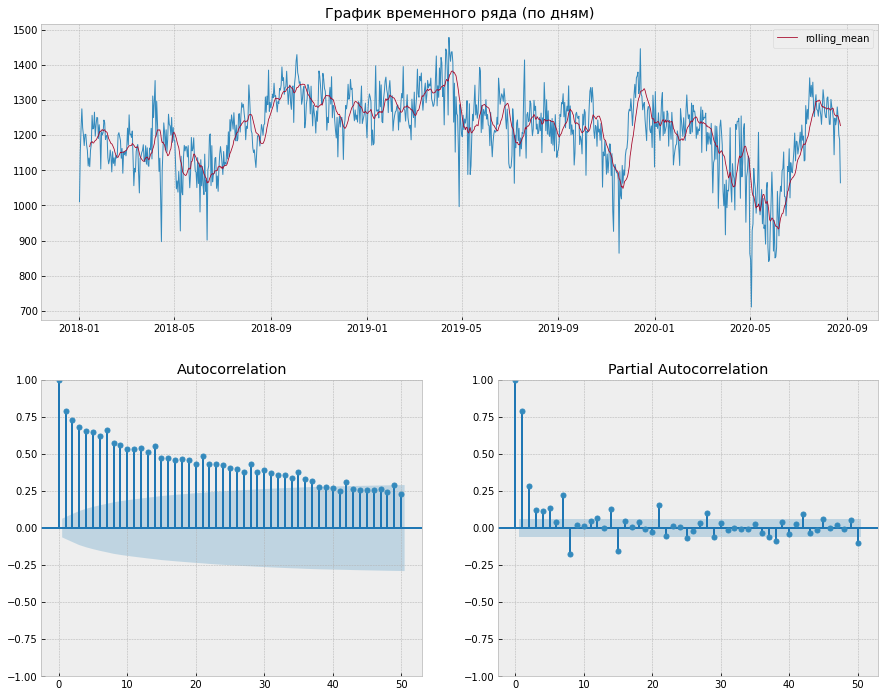

In [11]:
# Визуализируем временной ряд 

plot_timeseries(sale_price_timeseries)

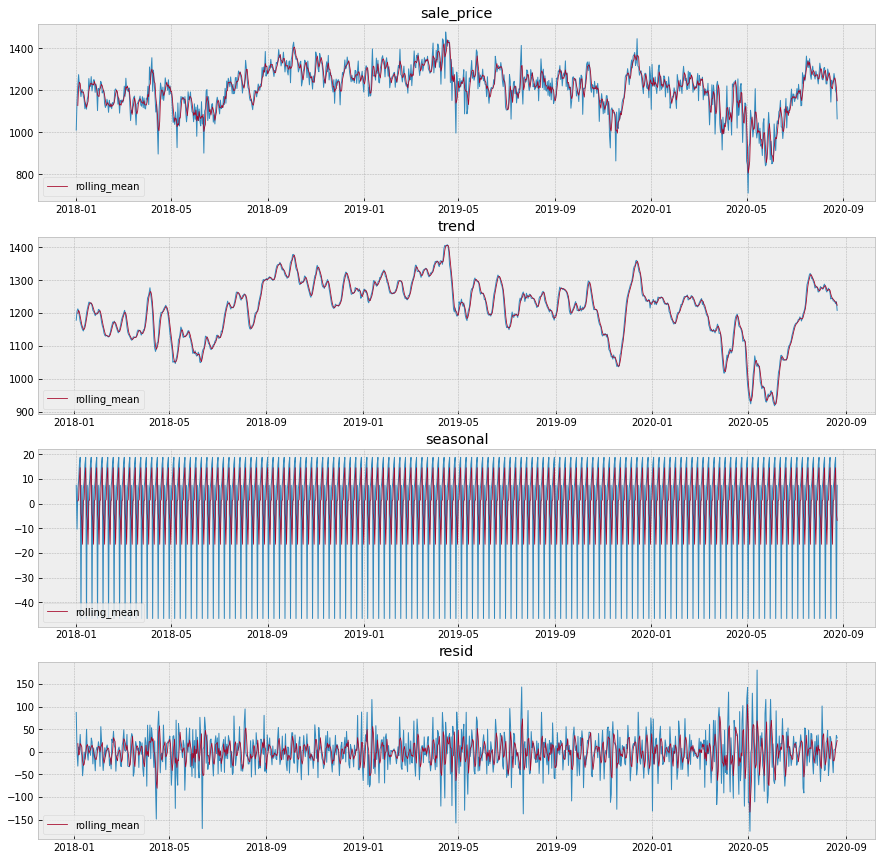

In [12]:
# Разложим данные ряд на компоненты: тренд, сезон и шум

start_date = '2018-01-01'
end_date = '2020-08-24'
plot_seasonal_decompose_timeseries(sale_price_timeseries, start_date, end_date)

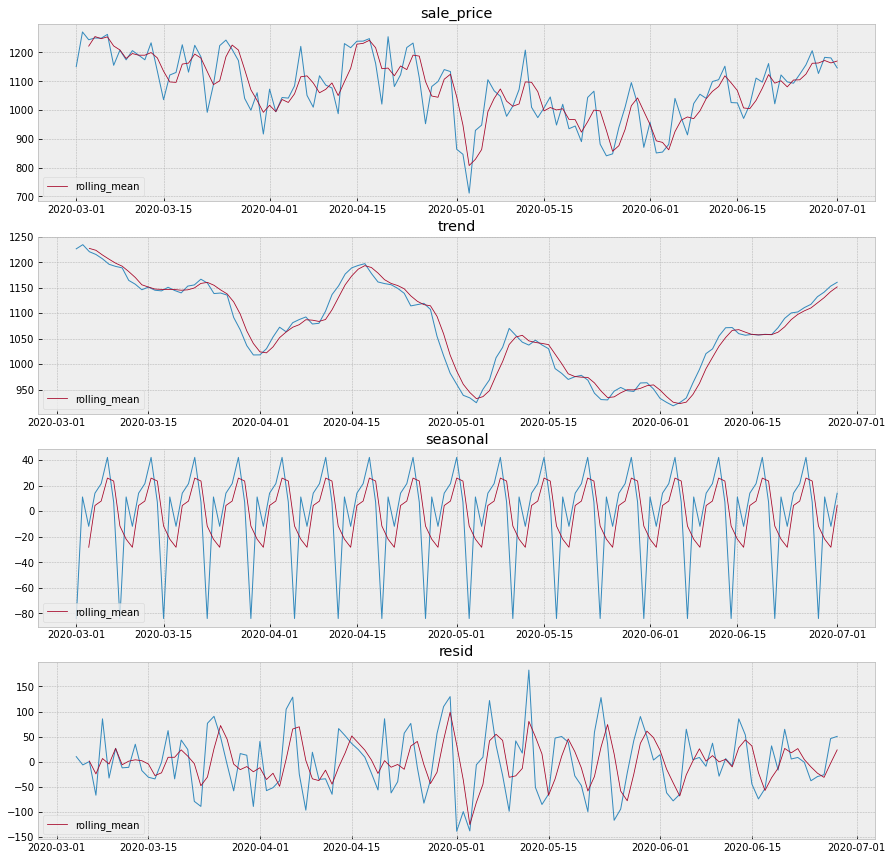

In [13]:
# Посмотри на компоненты поближе

start_date = '2020-03-01'
end_date = '2020-07-01'
plot_seasonal_decompose_timeseries(sale_price_timeseries, start_date, end_date)

По графикам компоненты сезона "seasonal", автокорреляции ACF и частной автокорреляции PACF отчетливо виден недельный цикл (7 дней) ряда.  
Также по графикам можно сделать вывод о годовой сезонности, так как на ACF видна долго затухающая авторегрессия, а на компоненте тренда "trend" можно различить понижение стоимости электроэнергии в летний период по сравнению с зимним из года в год.  
Соответственно необходимо учесть мультисезонность: неделя и год.  

По тесту Дики-Фуллер, ряд стационарен. Но присутствует небольшой тренд (готодвая сезонность). То есть стационарность ряда можно улучшить. 

Критерий Дики-Фуллера: p_value = 0.00000
Единичных корней нет => ряд стационарен


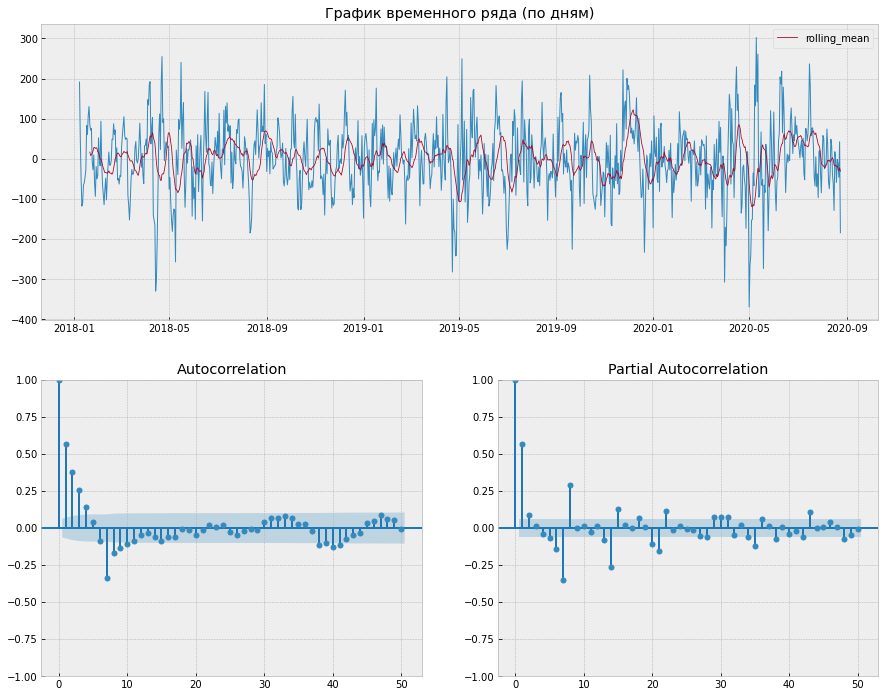

In [14]:
# Возьмём сезонную разность в 7 дней

sale_price_timeseries_diff_season = sale_price_timeseries.diff(7).dropna()
test_dickey_fuller(sale_price_timeseries_diff_season)
plot_timeseries(sale_price_timeseries_diff_season)

Ряд стал более стационарным.  
Для прогнозирования ряда будем использовать модель SARIMAX с использованием мультисезонности и дополнительных экзогенных регрессоров из датасета 'df'.  
Так как SARIMAX поддерживает только одну сезонность, в параметрах модели зададим недельную сезонность, а годовую сезонность зададим при помощи экзогенных регрессоров в виде ряда Фурье.  

In [15]:
# Поделим timeseries на обучающую и валидационные выборки. 
# Так как задача стоит в предсказании среднесуточной цены на месяц вперед, то и для валидационные выборки возьмем 1 месяц.

sale_price_train = sale_price_timeseries[:-31]
sale_price_valid = sale_price_timeseries[-31:]

### Базовая модель SARIMAX
Посмотрим на предсказательную способность модели SARIMAX только с timeseries и одним недельным циклом.  

Необходимо определить парамметры для SARIMAX: (p,d,q)x(P,D,Q)m  
У нас уже есть: D=1, m=7  
При помощи auto_arima определим что: p, q, P, Q, d

In [16]:
# Подберем параметры SARIMAX
parameter_search = auto_arima(sale_price_train,
                              D=1,
                              m=7,  
                              n_jobs=-1,
                              trace=True, error_action='ignore')

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[7] intercept   : AIC=inf, Time=3.88 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=10928.632, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=10339.232, Time=0.66 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=10415.118, Time=0.68 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=10926.746, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=10554.670, Time=0.27 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=10265.491, Time=1.41 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=2.35 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=10138.604, Time=2.02 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=10144.487, Time=0.97 sec
 ARIMA(1,0,0)(1,1,2)[7] intercept   : AIC=inf, Time=3.87 sec
 ARIMA(1,0,0)(0,1,2)[7] intercept   : AIC=10139.785, Time=2.60 sec
 ARIMA(1,0,0)(2,1,2)[7] intercept   : AIC=inf, Time=4.60 sec
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=10749.901, Time=1.18 sec
 ARIMA(2,0,0)(1,1,1)[7] intercept   : AIC=i

In [17]:
model = sm.tsa.statespace.SARIMAX(sale_price_train,
                                  order=(1,0,0),
                                  seasonal_order=(1,1,1,7), n_jobs=-1).fit()
model.summary().tables[1]  

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.7660,0.018,41.978,0.000,0.730,0.802
ar.S.L7,0.1086,0.035,3.132,0.002,0.041,0.176
ma.S.L7,-0.9274,0.015,-60.972,0.000,-0.957,-0.898
sigma2,3140.0056,105.942,29.639,0.000,2932.362,3347.649


In [18]:
sale_price_forecast = model.predict(start='2020-07-25',
                                    end='2020-08-24',
                                    dynamic=True)

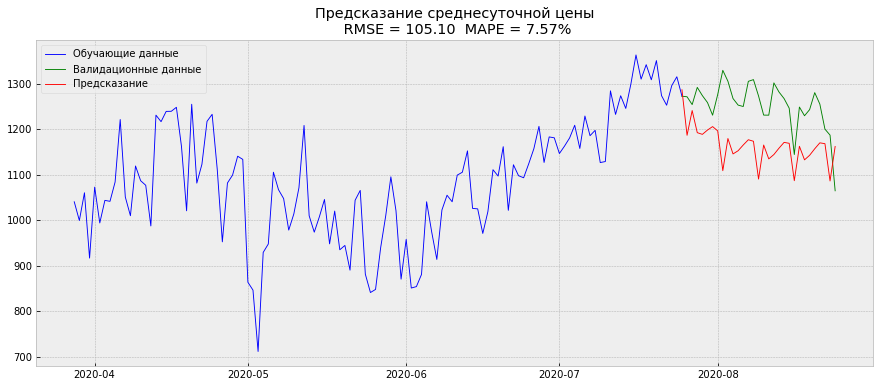

In [19]:
plot_forecast_timeseries(sale_price_timeseries[-150:-30], sale_price_valid, sale_price_forecast)

Критерий Дики-Фуллера: p_value = 0.00001
Единичных корней нет => ряд стационарен


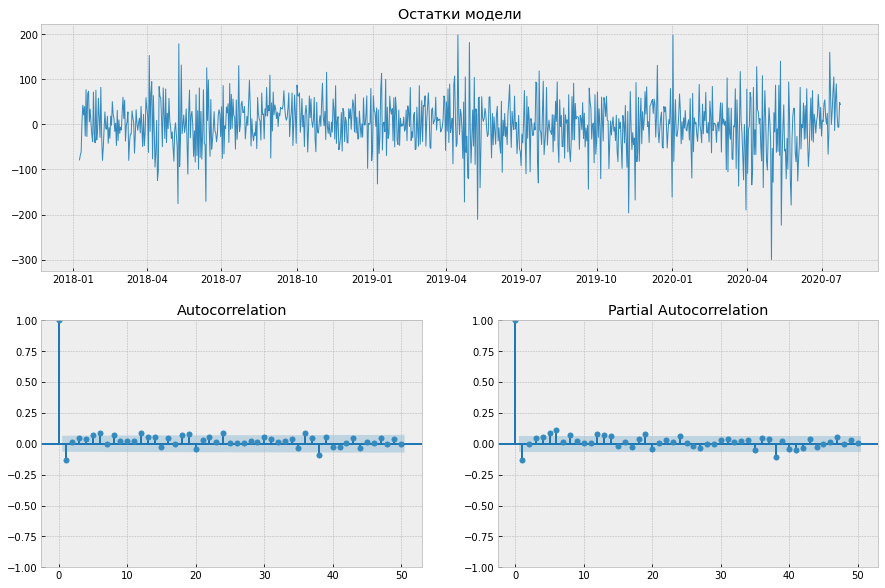

In [20]:
# Посмотрим на остатки модели:

resid = model.resid[8:]
test_dickey_fuller(resid)
plot_remains(resid)

Остатки модели в норме, похожи на "белый шум".  
В прогнозе наблюдается недельный цикл, но видно как не хватает учета тренда от других факторов

### Модель SARIMAX с годовой сезонностью 
Посмотрим на предсказательную способность модели SARIMAX только с timeseries с недельным циклом и годовой сезонностью   

Годовую сезонность зададим при помощи экзогенных регрессоров в виде ряда Фурье.

In [21]:
# Создадим экзогенный регрессор для годовой сезонности в виде ряда Фурье (k=2 принято исходя из перебора по наименьшему AIC)

four_terms = FourierFeaturizer(365.25, 2)
_, exog_year = four_terms.fit_transform(sale_price_timeseries)
exog_year.set_index(sale_price_timeseries.index, inplace=True)

In [22]:
# Поделим экзогенные регрессоры на обучающие, тестовые данные и для прогноза 

exog_train = exog_year[:-31]
exog_valid = exog_year[-31:]

In [23]:
model = sm.tsa.statespace.SARIMAX(sale_price_train,
                                  order=(2,0,0),
                                  seasonal_order=(1,1,1,7),
                                  exog=exog_train,
                                  seasonal=True).fit()
model.summary().tables[1] 

,coef,std err,z,P>|z|,[0.025,0.975]
FOURIER_S365-0,-41.5694,17.349,-2.396,0.017,-75.573,-7.565
FOURIER_C365-0,29.1808,14.465,2.017,0.044,0.830,57.532
FOURIER_S365-1,37.7978,13.877,2.724,0.006,10.599,64.997
FOURIER_C365-1,-19.1509,14.112,-1.357,0.175,-46.810,8.509
ar.L1,0.6237,0.027,22.690,0.000,0.570,0.678
ar.L2,0.1620,0.030,5.461,0.000,0.104,0.220
ar.S.L7,0.0950,0.033,2.838,0.005,0.029,0.161
ma.S.L7,-0.9392,0.014,-68.846,0.000,-0.966,-0.912
sigma2,3008.7822,106.416,28.274,0.000,2800.210,3217.354


In [24]:
sale_price_forecast = model.predict(start='2020-07-25',
                                    end='2020-08-24',
                                    exog=exog_valid,
                                    dynamic=True)

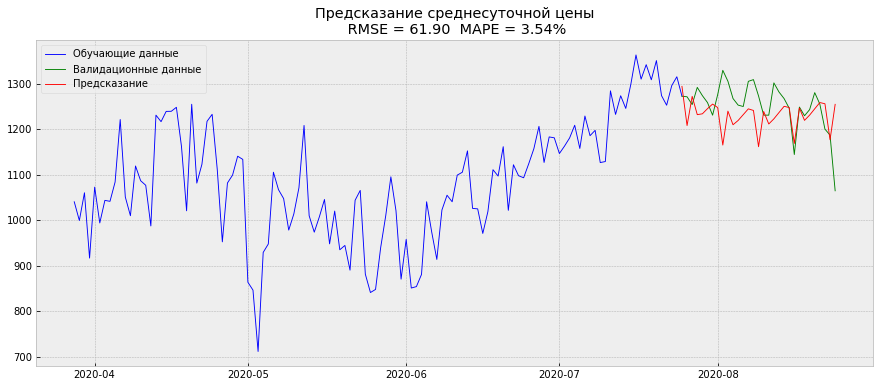

In [25]:
plot_forecast_timeseries(sale_price_timeseries[-150:-30], sale_price_valid, sale_price_forecast)

Критерий Дики-Фуллера: p_value = 0.00000
Единичных корней нет => ряд стационарен


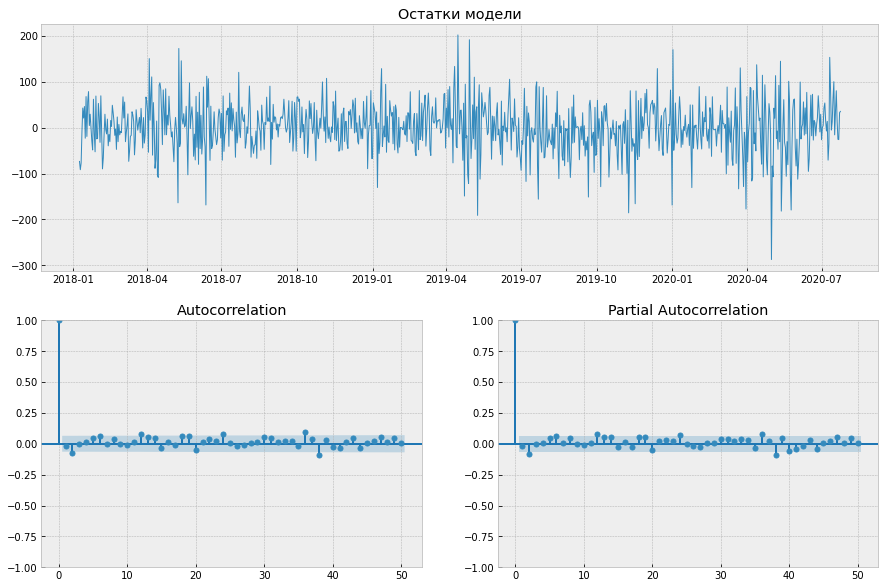

In [26]:
# Посмотрим на остатки модели:

resid = model.resid[8:]
test_dickey_fuller(resid)
plot_remains(resid)

Остатки модели также в норме, похожи на "белый шум". Ошибка RMSE уменьшилась почти вдвое.  
В прогноз стал лучше, но есть подозрение, что тренд идет не в том направлении.

### Модель SARIMAX с годовой сезонностью и доп. признаками

#### Извлечение признаков
Для дальнейшего улучшения модели необходимо сгенерировать дополнительные признаки.  
Идея в том, чтобы извлечь  побольше признаков из датасета, а при помощи метода .summary() модели SARIMAX посмотреть на их значимость и удалить менее значимые признаки для облегчения модели.  
Так же придется добавить признаки на месяц вперед (поверх начального датасета) для выявления закономерностей и дальнейшего прогноза.

In [27]:
# Сначала нужно 'пощупать' существующие начальные данные, их не много.

df_per_day_feature = df_per_day.copy()
df_per_day_feature.describe()

,plan_HPS,plan_APS,plan_TPS,TPS_min,TPS_max,consumption,export,import,plan_SPS,plan_WPS,plan_RES,price_null_offer,price_null_offer_over_min,sale_price
count,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.0,967.000000,967.000000,967.000000
mean,534.579729,1560.423622,3913.613816,3025.442917,4477.095770,5747.527248,1515.225917,1427.516439,9.413483,2.601912,0.0,82868.075808,5942.294245,1210.504163
std,114.409259,124.423478,636.874721,529.009891,630.298376,615.024034,109.097135,110.820538,5.784949,2.365142,0.0,8655.763307,1021.839435,104.486602
min,337.907153,1191.379444,2404.995767,1953.356542,2956.321325,4586.330428,1222.567047,1114.728272,0.884278,0.169167,0.0,66904.665417,2157.842667,711.211722
25%,446.986568,1479.181256,3395.302957,2556.887929,3975.716379,5221.964947,1439.487129,1353.850369,4.476347,1.085694,0.0,75776.910000,5721.056688,1152.105944
50%,507.963219,1548.313889,3933.616067,3013.527308,4503.596342,5665.107361,1513.601008,1429.708272,8.347972,1.866389,0.0,81361.686667,6187.414917,1224.919917
75%,609.997544,1651.488889,4492.140664,3538.569832,5047.145113,6331.166260,1598.785069,1511.971439,14.130069,3.203222,0.0,91406.747500,6544.153396,1281.125639
max,803.983833,1861.824956,5110.888331,4034.476094,5690.059617,6921.228033,1851.747431,1747.812353,22.252917,16.076250,0.0,99855.681250,8189.065917,1477.926611


In [28]:
# 'plan_RES' состоит только из нулей, можно смело удалять

df_per_day_feature = df_per_day_feature.drop(columns = 'plan_RES', axis=1)

<AxesSubplot:>

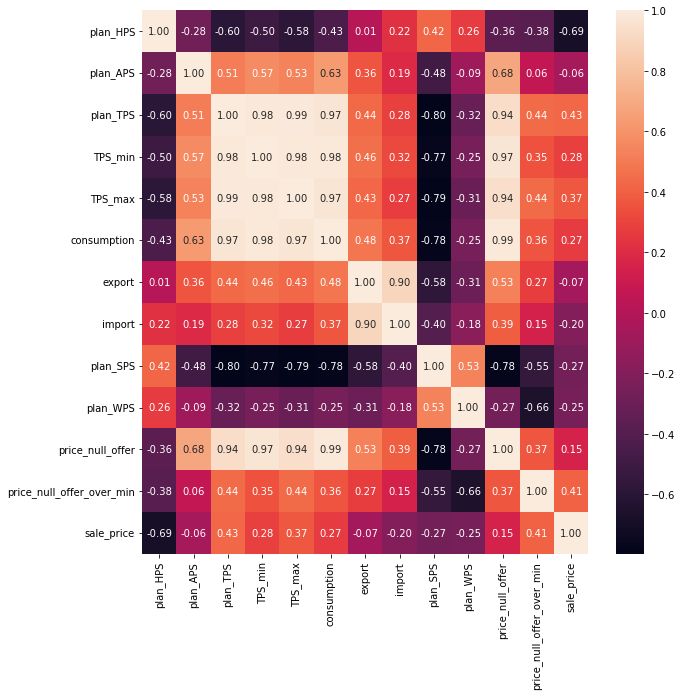

In [29]:
# Посмотрим на корреляцию данных

corr = df_per_day_feature.corr()
fig = plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, annot_kws={'size':10}, fmt='.2f')

In [30]:
# столбцы: "price_null_offer", "consumption", "TPS_min", "TPS_max", "export" и "plan_SPS"
# сильно коррелируют между собой, а с целевой переменной - слабо, т.е. можно тоже удалять

df_per_day_feature = df_per_day_feature.drop(columns = ['price_null_offer', 'consumption', 'plan_SPS', 
                                                        'export', 'TPS_min', 'TPS_max', 'plan_APS'], axis=1)

<AxesSubplot:>

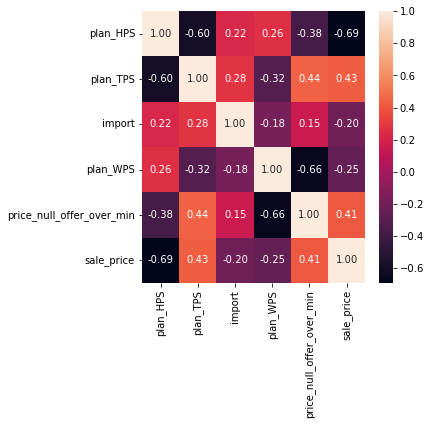

In [31]:
# Посмотрим еще раз на оставшуюся корреляцию данных
corr = df_per_day_feature.corr()
fig = plt.figure(figsize=(5,5))
sns.heatmap(corr, annot=True, annot_kws={'size':10}, fmt='.2f')

<AxesSubplot:>

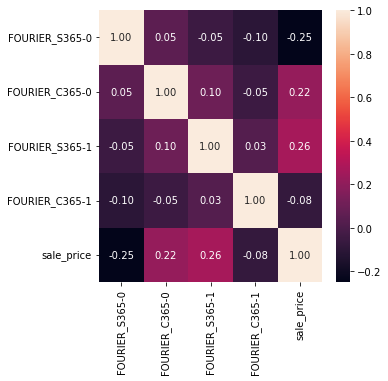

In [32]:
# Посмотрим на корреляцию ряда Фурье с целевой переменной 

exog_year['sale_price'] = df_per_day_feature['sale_price']
corr = exog_year.corr()
fig = plt.figure(figsize=(5,5))
sns.heatmap(corr, annot=True, annot_kws={'size':10}, fmt='.2f')

In [33]:
# столбец "FOURIER_C365-1" слабо коррелируют с целевой переменной, т.е. можно удалять

exog_year = exog_year.drop(columns = ['FOURIER_C365-1', 'sale_price'], axis=1)

In [34]:
# Нормализуем данные из датасета

ss = StandardScaler()
list_columns = df_per_day_feature.columns.tolist()
df_per_day_feature = pd.DataFrame(ss.fit_transform(df_per_day_feature), columns=list_columns, index=df_per_day_feature.index)

In [35]:
# Объединим регрессоры ежегодного сезона и данные из датасета

df_feature = pd.concat([exog_year, df_per_day_feature], axis=1)

In [36]:
# Расширим общий датасет на 31 день для прогноза

add_index_forecast = pd.date_range('2018-01-01', '2020-09-24', freq='1d')
df_feature = df_feature.reindex(add_index_forecast, fill_value=0)
sale_price_timeseries = sale_price_timeseries.reindex(add_index_forecast, fill_value=0)

In [37]:
df_feature.rename(columns={'FOURIER_S365-0':'S365_0', 'FOURIER_C365-0':'C365_0', 'FOURIER_S365-1':'S365_1'}, inplace=True)

In [38]:
df_feature.head()

,S365_0,C365_0,S365_1,plan_HPS,plan_TPS,import,plan_WPS,price_null_offer_over_min,sale_price
2018-01-01,0.017202,0.999852,0.034398,-1.509092,0.123796,-0.001731,-0.824559,-0.490780,-1.909324
2018-01-02,0.034398,0.999408,0.068755,-1.207110,0.359654,1.004799,-0.651940,-0.399742,-0.564891
2018-01-03,0.051584,0.998669,0.103031,-0.869829,0.483426,0.929059,-0.768343,0.179242,0.099881
2018-01-04,0.068755,0.997634,0.137185,-0.739324,0.727263,0.866656,-0.661153,-0.187636,0.616956
2018-01-05,0.085906,0.996303,0.171177,-0.664408,0.831817,1.145620,-0.957084,-0.423824,0.101965


In [39]:
# Создадим признаки из лагов и по агрегированным данным в соответствии с годом, месяцем, днем

def code_mean(data, cat_feature, real_feature):
    '''
    Арегирующая функция для вычисления среднего по категории
    '''
    return dict(data.groupby(cat_feature)[real_feature].mean())


def code_max(data, cat_feature, real_feature):
    '''
    Арегирующая функция для вычисления максимального по категории
    '''
    return dict(data.groupby(cat_feature)[real_feature].max())


def code_min(data, cat_feature, real_feature):
    '''
    Арегирующая функция для вычисления минимального по категории
    '''
    return dict(data.groupby(cat_feature)[real_feature].min())


def code_std(data, cat_feature, real_feature):
    '''
    Арегирующая функция для вычисления стандартного отклонения по категории
    '''
    return dict(data.groupby(cat_feature)[real_feature].std())


def prepareData(data, lag_start=7*5, lag_end=7*5*2, lag_step=7, test_size=31, years=3, roll_size=7): 
    '''
    Функция для вычисления лагов и агрегированных данных
    '''
    new_data = data.copy()    
    list_date_columns = new_data.columns.tolist()
    
    # создание лагов
    year = 52*7 # будем брать лаги в каждом году для получения годовой зависимости

    for year in range(0, year*years, year):
        for col in list_date_columns:
            for i in range(lag_start+year, lag_end+year, lag_step):
                new_data[f"{col}_lag_{i}"] = new_data[col].shift(i)

    new_data['year'] = new_data.index.year
    new_data['month'] = new_data.index.month
    new_data['day'] = new_data.index.day
    new_data['weekday'] = new_data.index.weekday
    new_data['is_weekend'] = new_data.weekday.isin([5,6])*1
    
    for col in list_date_columns:
        new_data[f'{col}_year_mean']= list(map(code_mean(new_data[:-test_size], 'year', col).get, new_data.year))
        new_data[f'{col}_year_max'] = list(map(code_max(new_data[:-test_size], 'year', col).get, new_data.year))
        new_data[f'{col}_year_min'] = list(map(code_min(new_data[:-test_size], 'year', col).get, new_data.year))
        new_data[f'{col}_year_std'] = list(map(code_std(new_data[:-test_size], 'year', col).get, new_data.year))
        
        new_data[f'{col}_month_mean']= list(map(code_mean(new_data[:-test_size], 'month', col).get, new_data.month))
        new_data[f'{col}_month_max'] = list(map(code_max(new_data[:-test_size], 'month', col).get, new_data.month))
        new_data[f'{col}_month_min'] = list(map(code_min(new_data[:-test_size], 'month', col).get, new_data.month))
        new_data[f'{col}_month_std'] = list(map(code_std(new_data[:-test_size], 'month', col).get, new_data.month))
        
        new_data[f'{col}_day_mean']= list(map(code_mean(new_data[:-test_size], 'day', col).get, new_data.day))
        new_data[f'{col}_day_max'] = list(map(code_max(new_data[:-test_size], 'day', col).get, new_data.day))
        new_data[f'{col}_day_min'] = list(map(code_min(new_data[:-test_size], 'day', col).get, new_data.day))
        new_data[f'{col}_day_std'] = list(map(code_std(new_data[:-test_size], 'day', col).get, new_data.day))
                
        new_data[f'{col}_weekday_mean']= list(map(code_mean(new_data[:-test_size], 'weekday', col).get, new_data.weekday))
        new_data[f'{col}_weekday_max'] = list(map(code_max(new_data[:-test_size], 'weekday', col).get, new_data.weekday))
        new_data[f'{col}_weekday_min'] = list(map(code_min(new_data[:-test_size], 'weekday', col).get, new_data.weekday))
        new_data[f'{col}_weekday_std'] = list(map(code_std(new_data[:-test_size], 'weekday', col).get, new_data.weekday))
        
        new_data[f'{col}_roll_mean'] = new_data[col].shift(test_size).rolling(roll_size).mean()
 
    new_data = new_data.dropna()
    new_data = new_data.iloc[:,data.shape[1]:]

    return new_data

In [41]:
# Создадим датасет с новыми признаками

df_exog_test = prepareData(df_feature, lag_start=7*5, lag_end=7*5*2, lag_step=7, test_size=62, years=3)

# Обрежем временный ряд целевой переменной, в соответствии с новыми признаками 
sale_price_timeseries_test = sale_price_timeseries[df_exog_test.index[0]:]

In [42]:
# Поделим данные на обучающие, тестовые и прогнозные выборки

X_train = df_exog_test[:-62]
X_valid = df_exog_test[-62:-31]
X_submit = df_exog_test[-31:]

y_train = sale_price_timeseries_test[:-62]
y_valid = sale_price_timeseries_test[-62:-31]
y_submit = sale_price_timeseries_test[-31:]

#### Модель SARIMAX с годовой сезонностью и доп. признаками

In [44]:
model = sm.tsa.statespace.SARIMAX(y_train,
                                  order=(2,0,0),
                                  seasonal_order=(1,1,1,7),
                                  exog=X_train,
                                  seasonal=True, n_jobs=-1).fit()
model.summary().tables[1] 

,coef,std err,z,P>|z|,[0.025,0.975]
S365_0_lag_35,280.3016,2.75e+04,0.010,0.992,-5.37e+04,5.43e+04
S365_0_lag_42,-111.1966,1.32e+05,-0.001,0.999,-2.58e+05,2.58e+05
S365_0_lag_49,-501.0843,2.45e+04,-0.020,0.984,-4.85e+04,4.75e+04
S365_0_lag_56,-883.7150,5363.816,-0.165,0.869,-1.14e+04,9629.172
S365_0_lag_63,-1253.5470,9073.453,-0.138,0.890,-1.9e+04,1.65e+04
C365_0_lag_35,3242.1611,nan,nan,nan,nan,nan
C365_0_lag_42,3252.3550,3441.944,0.945,0.345,-3493.731,9998.441
C365_0_lag_49,3215.4459,3671.500,0.876,0.381,-3980.562,1.04e+04
C365_0_lag_56,3131.9684,4676.410,0.670,0.503,-6033.626,1.23e+04
C365_0_lag_63,3003.1313,nan,nan,nan,nan,nan


In [51]:
# Отберем наиболее значимые признаки с порогом уровня значимости альфа=0.5

feature_importances = {}
for item in model.summary().tables[1].data[1:-5]:
    if float(item[4].strip()) < 0.2:
        feature_importances[item[0].strip()] = float(item[4].strip())        
feature_importances = list(feature_importances.keys())
feature_importances

['C365_0_lag_42',
 'C365_0_lag_49',
 'S365_1_lag_49',
 'C365_0_lag_427',
 'C365_0_lag_791',
 'day',
 'C365_0_roll_mean',
 'plan_TPS_month_max',
 'import_day_std',
 'plan_WPS_day_mean',
 'plan_WPS_day_std']

In [52]:
# Оставим только значимые регрессоры и обучим модель заново

model = sm.tsa.statespace.SARIMAX(y_train,
                                  order=(2,0,0),
                                  seasonal_order=(1,1,1,7),
                                  exog=X_train[feature_importances],
                                  seasonal=True, n_jobs=-1).fit()

sale_price_forecast = model.predict(start='2020-07-25',
                                    end='2020-08-24',
                                    exog=X_valid[feature_importances],
                                    dynamic=True)

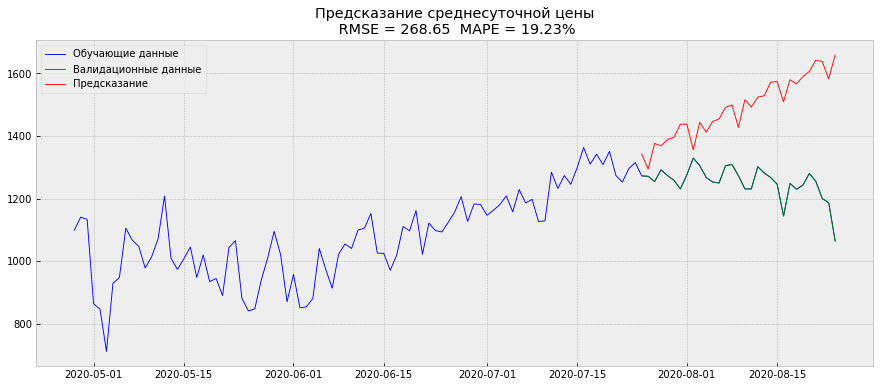

In [53]:
plot_forecast_timeseries(sale_price_timeseries[-150:-31], y_valid, sale_price_forecast)

**ЦЕНЫ В КОСМОСЕ!!!** 

При таком временном ряде целевой переменной (с мультисезонностью и нециклическим "неуловимым" трендом), я так и не смог адекватно настроить модель SARIMAX. Помимо существующего кода в данном ноутбуке, было перебрано большое количество параметров модели (включая сдвиги для стационарности ряда, логарифмическое преобразование и Бокса-Кокса), в т.ч. подходов к ней. Разные подходы к признакам (в количестве и переборке «что включать в модель, а что нет», с какими лагами). А также прогноз на одни сутки вперед с последующим использованием их в дальнейшей в обучающей выборки, прогноз каждого вспомогательного признака как отбельный временный ряд, которые в дальнейшем пошли как регрессоры к целевой переменной.   Единственное что хорошо выдает модель - это недельный цикл, но направление его в тренде желает лучшего. 

Будем прибывать другие методы прогноза.

### Модели линейной регрессии (с регуляризациями)

Идея похожая. Берем все извлеченные признаки из датасета, а при помощи коэффициентов при регуляризации Lasso, посмотрев на их значения (будут заниженные неважные признаки), удалим их для улучшения и облегчения модели.  

In [54]:
def regression_prediction_and_plot(estimator, X_train, y_train, X_valid, y_valid, alpha):
    '''
    Функция обучения линейных регрессионных моделей и предсказания с отрисовкой графика
    '''
    dict_estimator = {LinearRegression: {'n_jobs': -1},
                      Lasso: {'alpha': alpha},
                      Ridge: {'alpha': alpha}}      
    model = estimator(**dict_estimator[estimator])
    model.fit(X_train, y_train)
    prediction = model.predict(X_valid)
    prediction = pd.Series(prediction, index=X_valid.index)
    plot_forecast_timeseries(sale_price_timeseries[-150:-61], y_valid, prediction)
    
    if estimator == Lasso:
        coef_lasso = model.coef_
        return coef_lasso

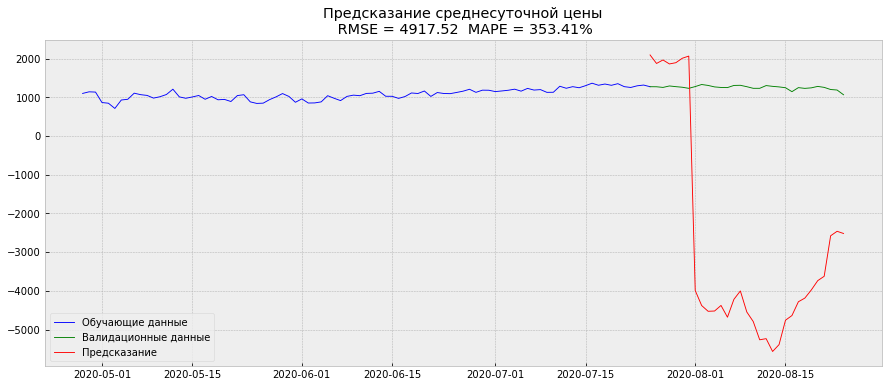

In [55]:
# Линейная регрессия LinearRegression

coef_lasso = regression_prediction_and_plot(LinearRegression, X_train, y_train, X_valid, y_valid, alpha=1)

ой, похоже перегруз модели

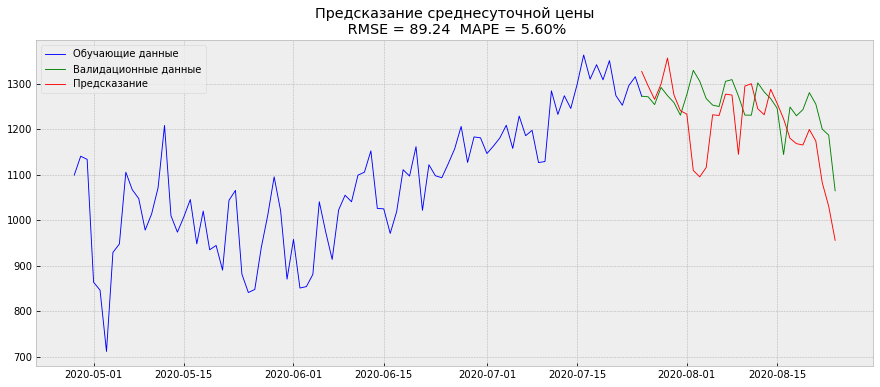

In [56]:
# Линейная регрессия с регуляризацией Ridge

regression_prediction_and_plot(Ridge, X_train, y_train, X_valid, y_valid, alpha=1)

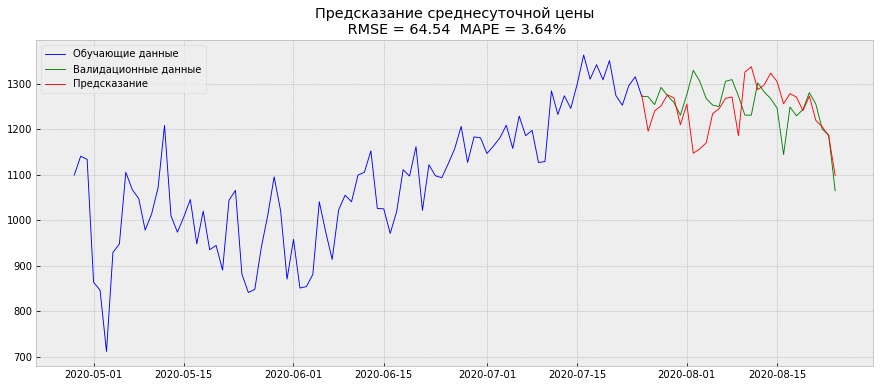

In [57]:
# Линейная регрессия с регуляризацией Lasso

coef_lasso = regression_prediction_and_plot(Lasso, X_train, y_train, X_valid, y_valid, alpha=0.8)

При применении моделей линейной регрессии с регуляризациями, ошибка составляет всего до 4-5%, а визуально прогноз похож на реальные данные, но есть сбои в недельных циклах.  
Теперь можно выбрать только значимые признаки и проверить модели на них.

<AxesSubplot:>

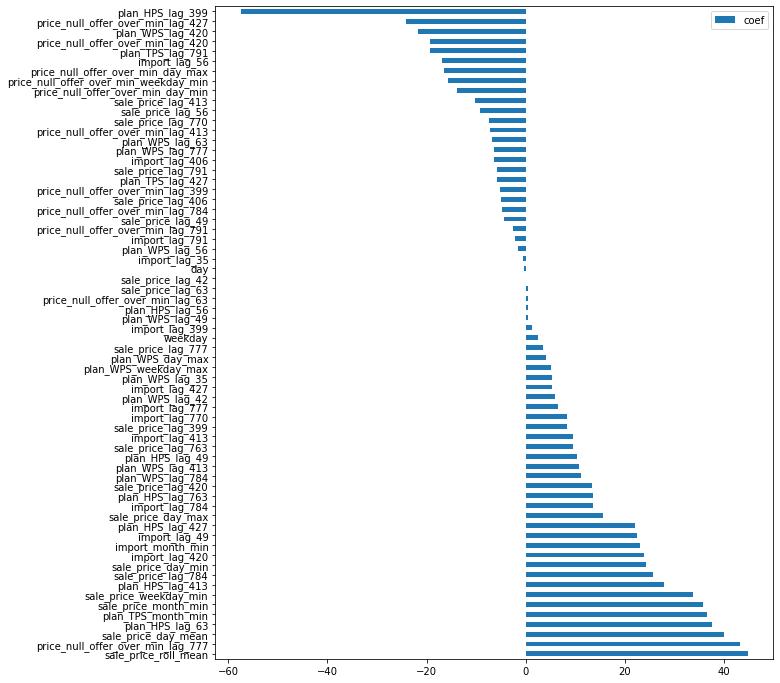

In [58]:
# Возьмем все признаки, коэффициенты при которых не равны нулю

df_coef_lasso = pd.DataFrame(coef_lasso, index=df_exog_test.columns, columns=['coef']).sort_values('coef', ascending=False)
list_feature_importance = df_coef_lasso[df_coef_lasso.coef != 0].index.tolist()
df_coef_lasso[df_coef_lasso.coef != 0].plot.barh(figsize=(10,12))

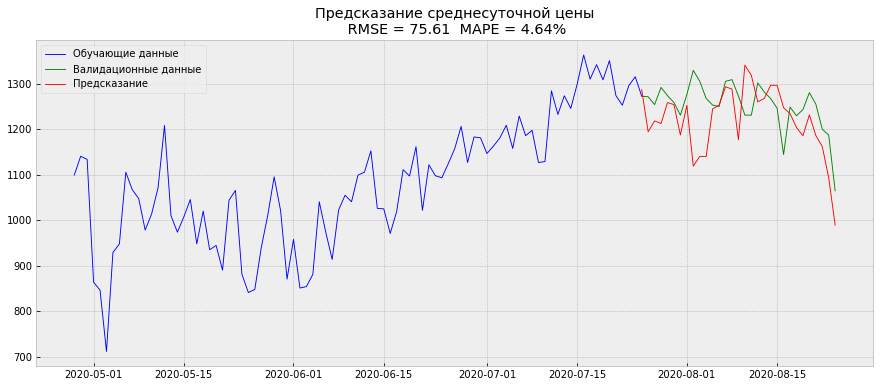

In [59]:
# Линейная регрессия с регуляризацией Ridge с отобранными признаками

regression_prediction_and_plot(Ridge, X_train[list_feature_importance],
                               y_train, X_valid[list_feature_importance], y_valid, alpha=1)

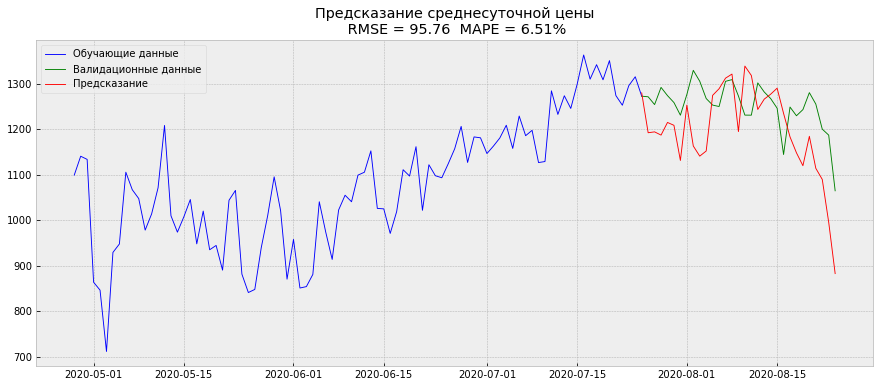

In [60]:
# Линейная регрессия LinearRegression с отобранными признаками

regression_prediction_and_plot(LinearRegression, X_train[list_feature_importance],
                               y_train, X_valid[list_feature_importance], y_valid, alpha=1)

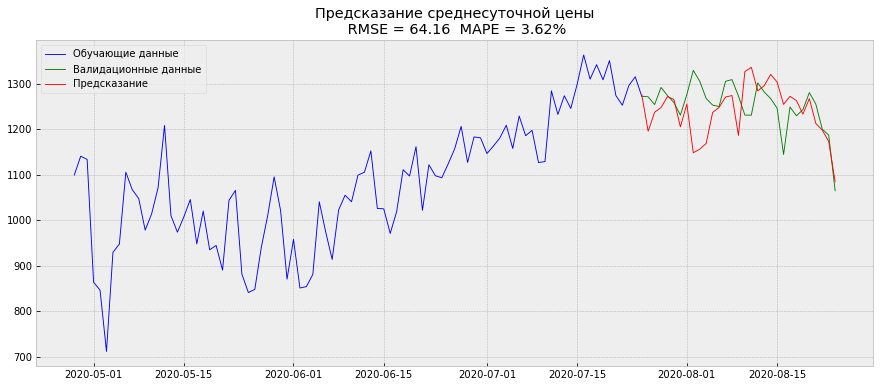

In [61]:
# Линейная регрессия с регуляризацией Lasso с отобранными признаками

coef_lasso = regression_prediction_and_plot(Lasso, X_train[list_feature_importance],
                                            y_train, X_valid[list_feature_importance], y_valid, alpha=0.75)

### Прогноз на месяц вперед

Для прогноза среднесуточной цены на электроэнергию выбираем модель линейной регрессии с регуляризацией Lasso и с отобранными признаками.  
Обучим модель на всех имеющихся данных и делаем предсказание на месяц вперед.

In [62]:
X_train = df_exog_test[:-31][list_feature_importance]
X_submit = df_exog_test[-31:][list_feature_importance]

y_train = sale_price_timeseries_test[:-31]

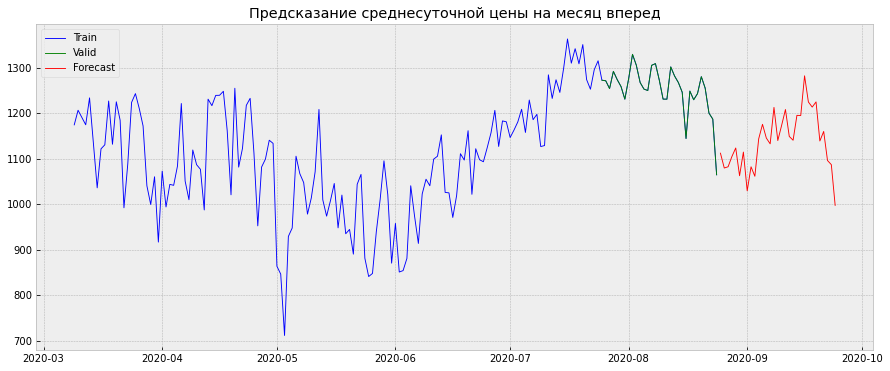

In [63]:
model = Lasso(alpha=0.75)
model.fit(X_train, y_train)
prediction = model.predict(X_submit)
prediction = pd.Series(prediction, index=X_submit.index)
    
with plt.style.context('bmh'):
    plt.figure(figsize=(15, 6))
    plt.plot(sale_price_timeseries[-200:-31], c="b", label='Train', lw=0.9)
    plt.plot(y_valid, c="g", label='Valid', lw=0.9)
    plt.plot(prediction, c="r", label='Forecast', lw=0.9)
    plt.legend()
    plt.title(f'Предсказание среднесуточной цены на месяц вперед')

In [64]:
# Итоговый прогноз и мое решение для данной задачи

prediction

2020-08-25    1112.001159
2020-08-26    1079.395656
2020-08-27    1082.138317
2020-08-28    1104.734301
2020-08-29    1123.432834
2020-08-30    1062.468108
2020-08-31    1114.418828
2020-09-01    1029.209028
2020-09-02    1082.113783
2020-09-03    1061.204374
2020-09-04    1143.436852
2020-09-05    1175.495749
2020-09-06    1145.270708
2020-09-07    1132.569901
2020-09-08    1212.628079
2020-09-09    1139.752692
2020-09-10    1173.124111
2020-09-11    1207.966757
2020-09-12    1148.827407
2020-09-13    1140.459079
2020-09-14    1195.130471
2020-09-15    1194.881370
2020-09-16    1282.085612
2020-09-17    1224.564401
2020-09-18    1213.348097
2020-09-19    1224.735192
2020-09-20    1138.745279
2020-09-21    1159.846278
2020-09-22    1095.905487
2020-09-23    1086.747887
2020-09-24     997.247972
Freq: D, dtype: float64